In [81]:
# Import
import pandas as pd
import darts
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Prophet
import matplotlib.pyplot as plt
from darts.utils.utils import SeasonalityMode
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, extract_trend_and_seasonality, ModelMode, remove_trend, remove_from_series
import glob 
import os
from darts.utils.missing_values import fill_missing_values
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import sys, os

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [9]:
# Merging all files and making the dataframe
#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join("./data" , "*.csv"))), ignore_index= True)
df = pd.read_csv('0.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Check the existent of nan values 
if df['value'].isna().sum() != 0 :
    df['value'] = fill_mising_values(df['value'])
else:
    print("No missing value")
    

No missing value


In [23]:
# Too long time series not supported
df = df.head(1000)
df

,timestamp,value,label
0,2017-04-30 16:00:00,1.901639,0
1,2017-04-30 16:01:00,1.786885,0
2,2017-04-30 16:02:00,2.000000,0
3,2017-04-30 16:03:00,1.885246,0
4,2017-04-30 16:04:00,1.819672,0
5,2017-04-30 16:05:00,1.885246,0
6,2017-04-30 16:06:00,1.885246,0
7,2017-04-30 16:07:00,1.934426,0
8,2017-04-30 16:08:00,1.967213,0
9,2017-04-30 16:09:00,1.950820,0


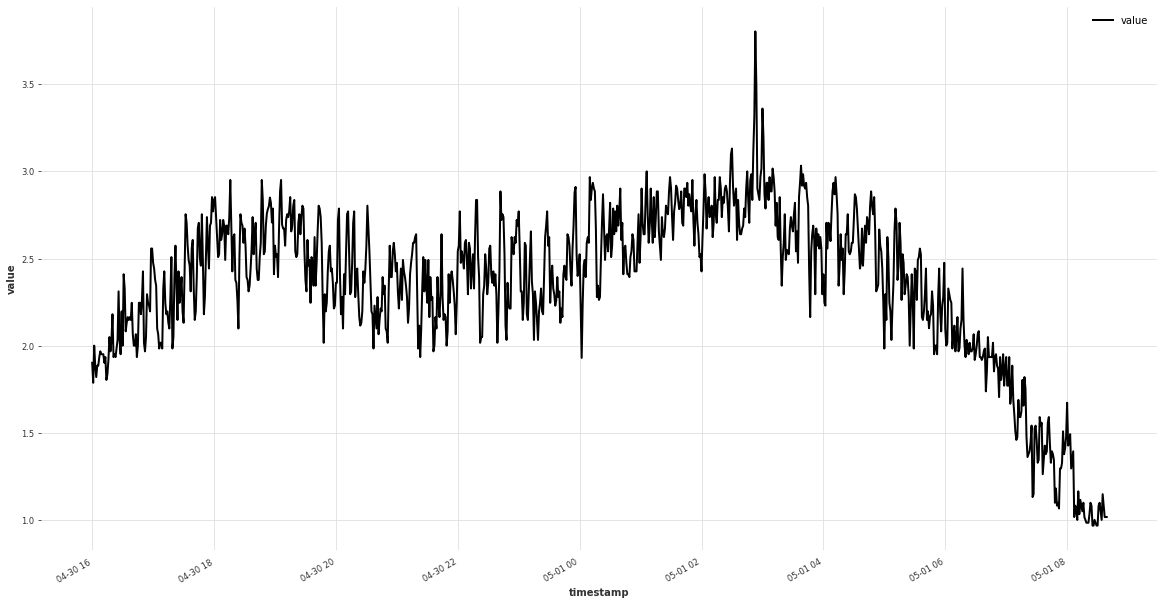

In [11]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, 'timestamp', 'value', freq='T')
# Set aside the last 36 months as a validation series
train, val = series[:-round(len(df) / 5)], series[-round(len(df) / 5):]

# Plot the time series
plt.rcParams["figure.figsize"] = (20,10)
series.plot()
plt.ylabel("value")
plt.show()

In [12]:
# Check occurence of seasonality and find the period of it
is_sesonal, m = check_seasonality(ts = series, m = None, max_lag = 100, alpha = 0.05)
print(is_sesonal)
print(m)

True
27


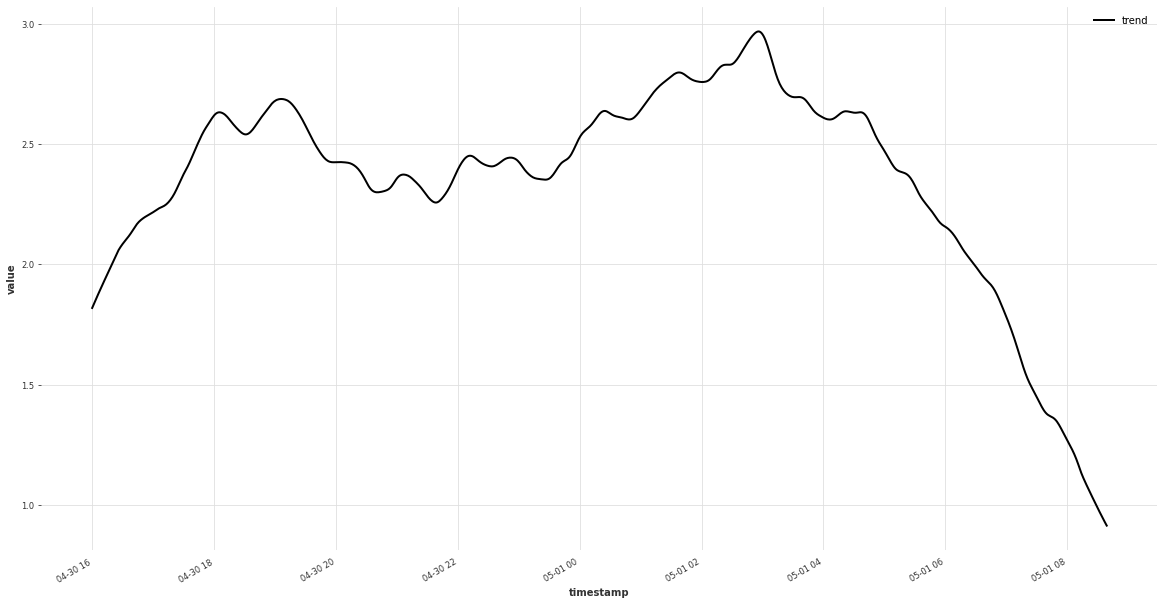

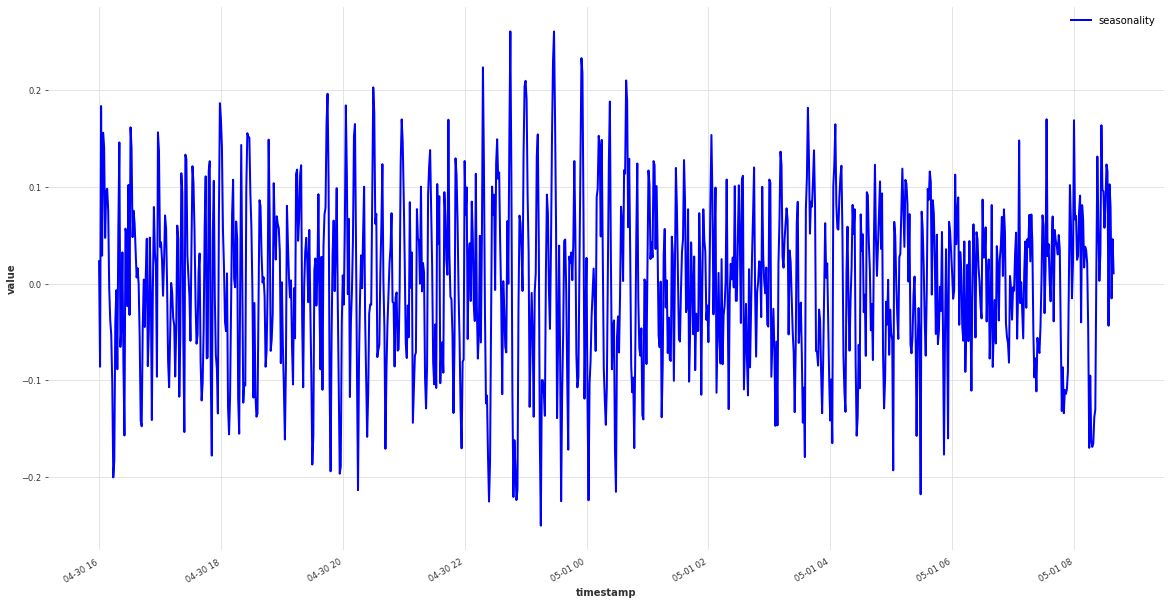

In [13]:
# Decompose trend and sesonality
trend,seasonality = extract_trend_and_seasonality(ts = series, model = ModelMode.ADDITIVE, method = "STL", freq = m)

trend.plot(label = "trend")
plt.ylabel("value")
plt.legend()
plt.show()


seasonality.plot(label = "seasonality", color = "blue")
plt.ylabel("value")
plt.show()


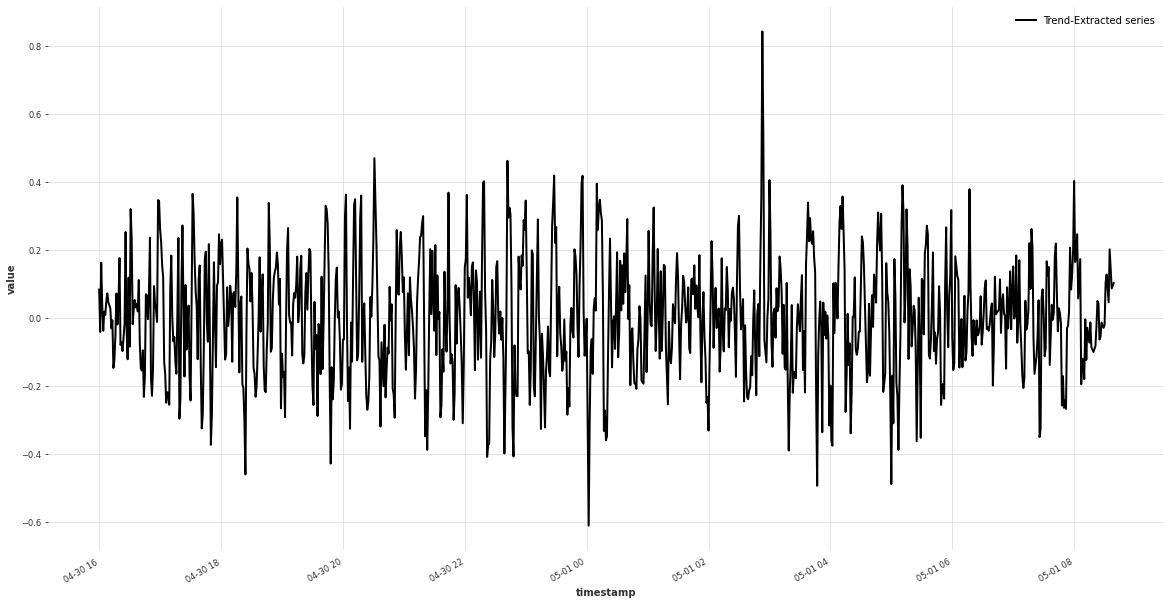

In [14]:
# Extract trend
series_minus_trend = remove_from_series(ts = series, other = trend, model = ModelMode.ADDITIVE )
series_minus_trend.plot(label = "Trend-Extracted series")
plt.ylabel("value")
plt.show()

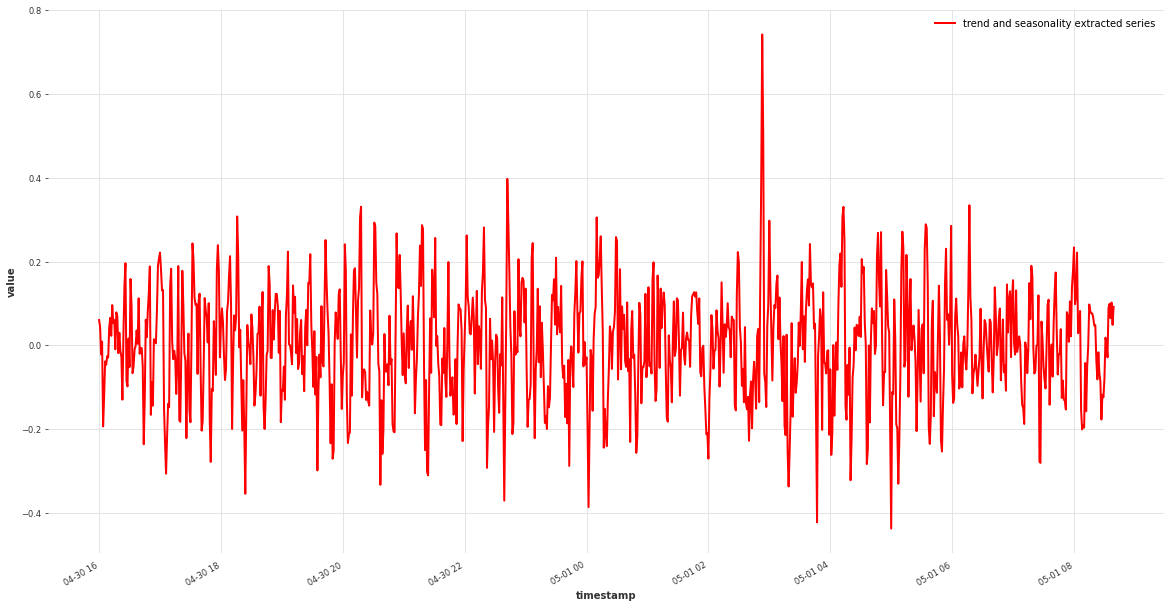

In [15]:
# Extract seasonality
series_minus_trend_and_sesonality = remove_from_series(ts = series_minus_trend, other = seasonality, model = ModelMode.ADDITIVE )
series_minus_trend_and_sesonality.plot(label = "trend and seasonality extracted series", color = "red")
plt.ylabel("value")
plt.show()

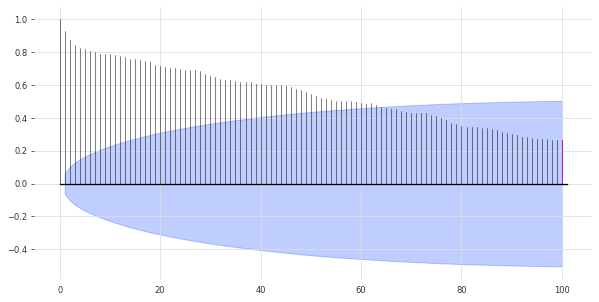

In [16]:
plot_acf(series, 100, max_lag=100)

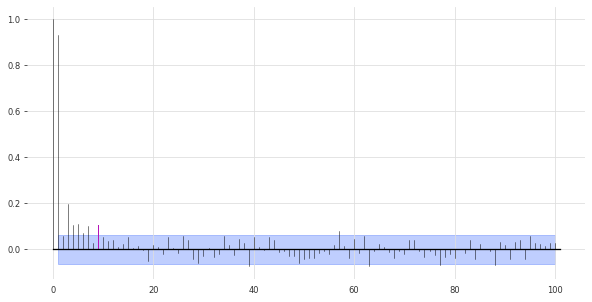

In [17]:
plot_pacf(series, 9, max_lag=100)

#### Plotting the timeserie with no trend and sesonality

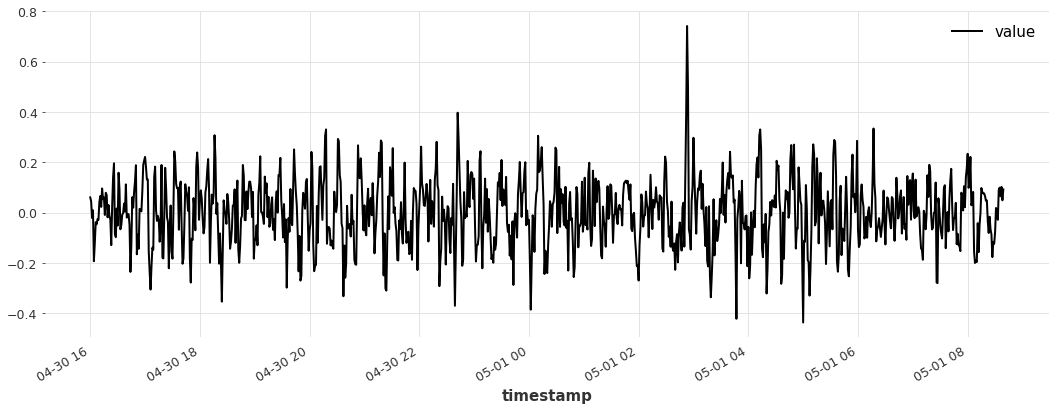

In [27]:
plt.rc('figure',figsize=(18,6))
plt.rc('font',size=15)
series_minus_trend_and_sesonality.plot()

#### Start outlier detection

In [70]:
outliers_fraction = float(.01)
scaler = StandardScaler()
dataframe_style = series_minus_trend_and_sesonality.pd_dataframe() 
np_scaled = scaler.fit_transform(dataframe_style.value.to_numpy().reshape(-1, 1))
data = pd.DataFrame(np_scaled)

#### Train isolation forest

In [73]:
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)
dataframe_style['anomaly'] = model.predict(data)

#### Visualization

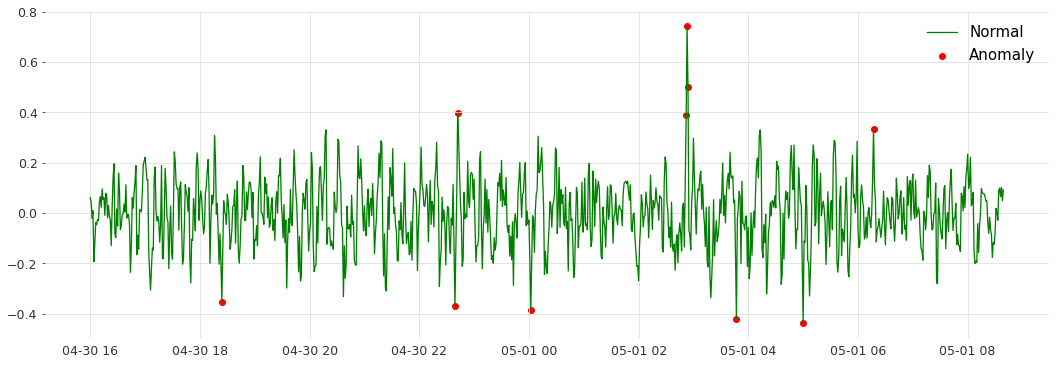

In [83]:
fig, ax = plt.subplots(figsize=(18,6))
a = dataframe_style.loc[dataframe_style['anomaly'] == -1, ['value']] #anomaly
ax.plot(dataframe_style.index, dataframe_style['value'], color='green', label = 'Normal')
ax.scatter(a.index,a['value'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

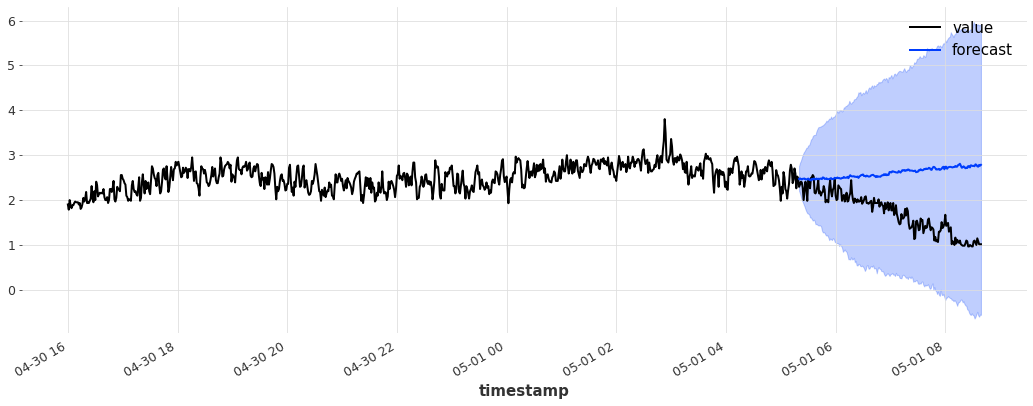

In [75]:
exp_model = ExponentialSmoothing(seasonal=SeasonalityMode.NONE)
exp_model.fit(train)
exp_prediction = exp_model.predict(len(val), num_samples=1000)
# Plotting the predictions
series.plot()
exp_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

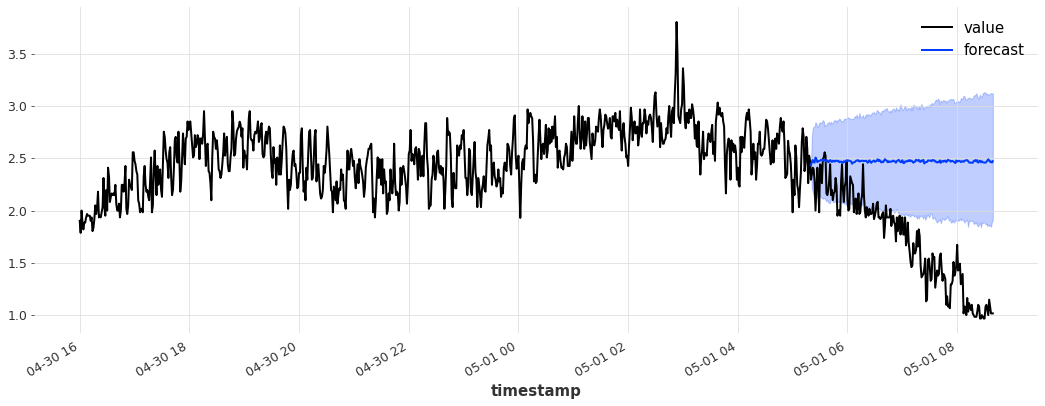

In [79]:
arima_model = ARIMA(9, 1, 5)
arima_model.fit(train)
arima_prediction = arima_model.predict(len(val), num_samples=1000)
# Plotting the predictions
series.plot()
arima_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

2022-09-03 01:19:12 cmdstanpy DEBUG: cmd: where.exe tbb.dll
cwd: None
2022-09-03 01:19:12 cmdstanpy DEBUG: TBB already found in load path
2022-09-03 01:19:12 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-09-03 01:19:12 prophet INFO: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-09-03 01:19:12 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-09-03 01:19:12 cmdstanpy DEBUG: input tempfile: C:\Users\LEGION\AppData\Local\Temp\tmpddc44vgy\2c8olxzr.json
2022-09-03 01:19:12 cmdstanpy DEBUG: input tempfile: C:\Users\LEGION\AppData\Local\Temp\tmpddc44vgy\dgdj809_.json
2022-09-03 01:19:12 cmdstanpy DEBUG: idx 0
2022-09-03 01:19:12 cmdstanpy DEBUG: running CmdStan, num_threads: None
2022-09-03 01:19:12 cmdstanpy DEBUG: CmdStan args: ['C:\\Users\\LEGION\\AppData\\Local\\Programs\\Python\\Python38\\Lib\\site-packages\\prophet\\stan_mo

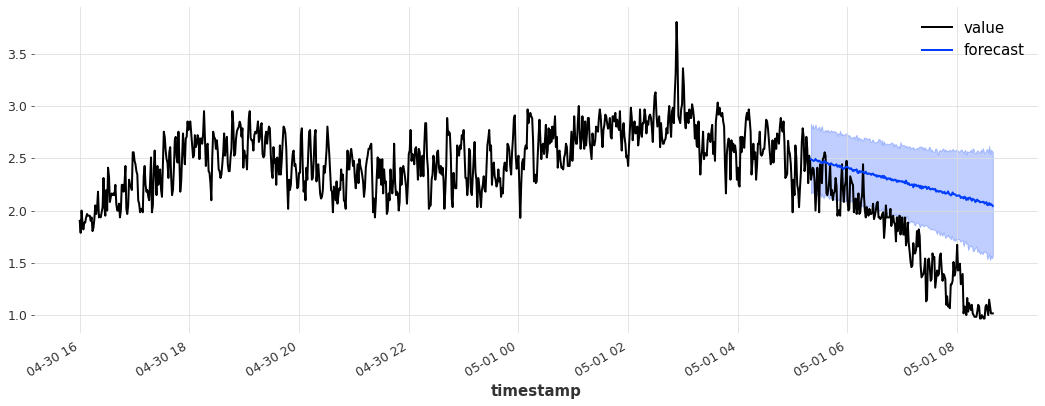

In [82]:
prophet_model = Prophet()
prophet_model.fit(train)
prophet_prediction = prophet_model.predict(len(val), num_samples=1000)
# Plotting the predictions
series.plot()
prophet_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()